In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

# import from parent level
import sys 
sys.path.append('..')
from path_parameters import TRAIN_PATH, TEST_PATH, OUTPUT_PATH

2022-04-19 10:00:01.088475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-19 10:00:01.088501: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_path = TRAIN_PATH
test_path = TEST_PATH
output_path = OUTPUT_PATH

### Prepare data

In [3]:
# List of dataset to use for training
train_files = ["ssp126", "ssp585", "historical", "hist-GHG"]

In [4]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['tas'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(test_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

In [5]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
assert len(X_train) == len(y_train_tas)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth[~nan_test_mask]

In [6]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [7]:
# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

### Prepare model

In [8]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2022-04-19 09:20:23.859776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-19 09:20:23.859817: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-19 09:20:23.859839: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Rivendell): /proc/driver/nvidia/version does not exist
2022-04-19 09:20:23.862246: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_tas.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [10]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

2022-04-19 09:20:26.791949: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70749D+06    |proj g|=  1.72407D+06

At iterate    1    f=  3.71036D+06    |proj g|=  7.42831D+05

At iterate    2    f=  3.51490D+06    |proj g|=  1.49563D+05

At iterate    3    f=  3.46951D+06    |proj g|=  1.42043D+05

At iterate    4    f=  3.20351D+06    |proj g|=  5.94007D+05

At iterate    5    f=  2.95567D+06    |proj g|=  4.36398D+05

At iterate    6    f=  2.85758D+06    |proj g|=  2.25022D+04

At iterate    7    f=  2.84913D+06    |proj g|=  4.76932D+04

At iterate    8    f=  2.84671D+06    |proj g|=  3.46697D+04

At iterate    9    f=  2.84134D+06    |proj g|=  1.05007D+04

At iterate   10    f=  2.83144D+06    |proj g|=  6.28869D+04

At iterate   11    f=  2.82109D+06    |proj g|=  8.04331D+04

At iterate   12    f=  2.80311D+06    |proj g|=  2.40932D+04

At iterate   13    f=  2.7


At iterate  130    f=  2.58587D+06    |proj g|=  2.24190D+03

At iterate  131    f=  2.58585D+06    |proj g|=  2.79750D+03

At iterate  132    f=  2.58580D+06    |proj g|=  2.94450D+03

At iterate  133    f=  2.58578D+06    |proj g|=  2.56336D+03

At iterate  134    f=  2.58575D+06    |proj g|=  8.93270D+02

At iterate  135    f=  2.58573D+06    |proj g|=  1.18283D+03

At iterate  136    f=  2.58573D+06    |proj g|=  1.28736D+03

At iterate  137    f=  2.58571D+06    |proj g|=  1.95435D+03

At iterate  138    f=  2.58570D+06    |proj g|=  2.90999D+03

At iterate  139    f=  2.58569D+06    |proj g|=  1.43511D+03

At iterate  140    f=  2.58569D+06    |proj g|=  4.47262D+02

At iterate  141    f=  2.58568D+06    |proj g|=  8.20142D+02

At iterate  142    f=  2.58567D+06    |proj g|=  1.81351D+03

At iterate  143    f=  2.58565D+06    |proj g|=  1.54297D+03

At iterate  144    f=  2.58564D+06    |proj g|=  3.59672D+03

At iterate  145    f=  2.58562D+06    |proj g|=  1.31718D+03

At iter


At iterate  263    f=  2.58393D+06    |proj g|=  1.03813D+03

At iterate  264    f=  2.58390D+06    |proj g|=  1.45241D+03

At iterate  265    f=  2.58390D+06    |proj g|=  5.11879D+02

At iterate  266    f=  2.58389D+06    |proj g|=  2.95263D+02

At iterate  267    f=  2.58388D+06    |proj g|=  8.25743D+02

At iterate  268    f=  2.58386D+06    |proj g|=  1.03577D+03

At iterate  269    f=  2.58385D+06    |proj g|=  8.29763D+02

At iterate  270    f=  2.58383D+06    |proj g|=  1.26921D+03

At iterate  271    f=  2.58382D+06    |proj g|=  1.36519D+03

At iterate  272    f=  2.58380D+06    |proj g|=  1.11041D+03

At iterate  273    f=  2.58375D+06    |proj g|=  6.07133D+02

At iterate  274    f=  2.58369D+06    |proj g|=  5.84574D+02

At iterate  275    f=  2.58367D+06    |proj g|=  1.32791D+03

At iterate  276    f=  2.58366D+06    |proj g|=  3.66233D+03

At iterate  277    f=  2.58362D+06    |proj g|=  1.89280D+03

At iterate  278    f=  2.58360D+06    |proj g|=  6.45343D+02

At iter


At iterate  396    f=  2.58339D+06    |proj g|=  2.01399D+02

At iterate  397    f=  2.58338D+06    |proj g|=  2.69567D+02

At iterate  398    f=  2.58338D+06    |proj g|=  4.63485D+02

At iterate  399    f=  2.58338D+06    |proj g|=  3.29704D+02

At iterate  400    f=  2.58338D+06    |proj g|=  4.20297D+02

At iterate  401    f=  2.58337D+06    |proj g|=  1.93236D+03

At iterate  402    f=  2.58337D+06    |proj g|=  7.53745D+02

At iterate  403    f=  2.58336D+06    |proj g|=  2.95688D+02

At iterate  404    f=  2.58336D+06    |proj g|=  3.33605D+02

At iterate  405    f=  2.58336D+06    |proj g|=  8.66143D+02

At iterate  406    f=  2.58335D+06    |proj g|=  5.65499D+02

At iterate  407    f=  2.58335D+06    |proj g|=  4.16843D+02

At iterate  408    f=  2.58335D+06    |proj g|=  1.80510D+02

At iterate  409    f=  2.58335D+06    |proj g|=  2.30235D+02

At iterate  410    f=  2.58335D+06    |proj g|=  3.05007D+02

At iterate  411    f=  2.58334D+06    |proj g|=  8.98692D+02

At iter


At iterate  529    f=  2.58321D+06    |proj g|=  3.44235D+02

At iterate  530    f=  2.58321D+06    |proj g|=  4.38551D+02

At iterate  531    f=  2.58321D+06    |proj g|=  2.79548D+02

At iterate  532    f=  2.58321D+06    |proj g|=  5.30286D+02

At iterate  533    f=  2.58321D+06    |proj g|=  4.31455D+02

At iterate  534    f=  2.58321D+06    |proj g|=  2.28372D+02

At iterate  535    f=  2.58320D+06    |proj g|=  2.58363D+02

At iterate  536    f=  2.58320D+06    |proj g|=  4.73510D+02

At iterate  537    f=  2.58320D+06    |proj g|=  1.11948D+03

At iterate  538    f=  2.58320D+06    |proj g|=  8.42535D+01

At iterate  539    f=  2.58320D+06    |proj g|=  8.42842D+01

At iterate  540    f=  2.58320D+06    |proj g|=  8.49009D+01

At iterate  541    f=  2.58320D+06    |proj g|=  2.88693D+02

At iterate  542    f=  2.58320D+06    |proj g|=  6.25956D+02

At iterate  543    f=  2.58320D+06    |proj g|=  3.76122D+02

At iterate  544    f=  2.58320D+06    |proj g|=  2.02234D+02

At iter


At iterate  662    f=  2.58309D+06    |proj g|=  5.72647D+01

At iterate  663    f=  2.58309D+06    |proj g|=  3.30886D+01

At iterate  664    f=  2.58309D+06    |proj g|=  4.55884D+01

At iterate  665    f=  2.58309D+06    |proj g|=  1.56333D+02

At iterate  666    f=  2.58309D+06    |proj g|=  1.07082D+02

At iterate  667    f=  2.58309D+06    |proj g|=  3.17234D+01

At iterate  668    f=  2.58309D+06    |proj g|=  6.25352D+01

At iterate  669    f=  2.58309D+06    |proj g|=  1.69054D+02

At iterate  670    f=  2.58309D+06    |proj g|=  2.36602D+02

At iterate  671    f=  2.58309D+06    |proj g|=  5.57643D+02

At iterate  672    f=  2.58309D+06    |proj g|=  1.02157D+02

At iterate  673    f=  2.58309D+06    |proj g|=  1.03099D+02

At iterate  674    f=  2.58309D+06    |proj g|=  3.29898D+01

At iterate  675    f=  2.58309D+06    |proj g|=  7.78195D+01



      fun: 2583088.028716583
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.72963792,   2.54742665,  -6.39252138,  -0.73356127,
       -24.21659289,  -0.10345556,  -3.27846438,  -0.16002167,
         5.16418843,  23.334656  , -12.4731136 ,  -1.76426405,
        -3.43403127,  -1.07751601,  -0.68388148,  -2.70781681,
        -9.13462405,  14.83110849])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 764
      nit: 676
     njev: 764
   status: 0
  success: True
        x: array([  8.50508259,   8.71069915,  -0.32230943,  -3.35942033,
        -3.94086148,  15.59330046,  -1.12821921,  13.94777817,
        -2.83273627,  -2.45195757,   8.36476384,  18.04742431,
        27.17658681, 111.65185625, 149.37146   ,  -0.50118268,
        -2.59872421,   0.63521512])

At iterate  676    f=  2.58309D+06    |proj g|=  2.42166D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18    676    764      1     0     0   2.422D+01   2.583D+06
  F =   2583088.0287165828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### Predict on testing set

In [11]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std = np.sqrt(standard_posterior_var) * train_tas_std

In [12]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=tas_truth.dims, coords=tas_truth.coords)

In [13]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

RMSE at 2050: 0.30960155783305154
RMSE at 2100: 0.3480264270235782
RMSE 2045-2055: 0.35032281944368954
RMSE 2090-2100: 0.36771933456306116
RMSE 2050-2100: 0.36454130470817603


[Text(0.5, 1.0, 'Difference')]

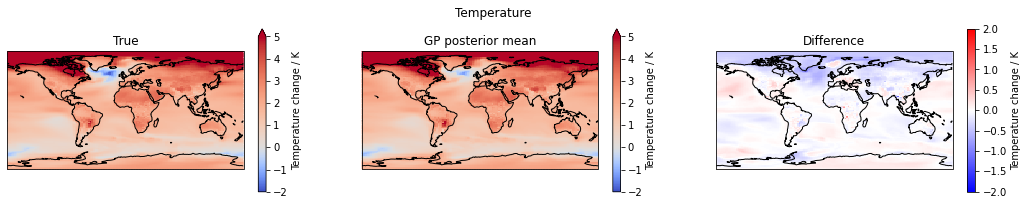

In [14]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Mostly CO2
- Really just CO2
- Small noise variance

In [15]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.63521512]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,8.710863945256119
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,8.505285001665037
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.03416507017643041
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.5449220652388289
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.08261615613029558
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.01924509, 15.59330063, 0.28036212..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.4736306372523688
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[8.36499675, 18.04742433, 27.17658681..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.07173395043664851


In [16]:
# Save predictions
posterior_tas_data.to_netcdf(output_path + 'climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
posterior_tas_std_data.to_netcdf(output_path + 'climatebench-gp-posterior-std-tas-test-2019-2100.nc')